In [49]:
pip install tslearn

  Obtaining dependency information for tslearn from https://files.pythonhosted.org/packages/97/22/8dba9a7149d51fe0b6163a5a6b7efc315ab3c097cb6b0d1fc649a03f2722/tslearn-0.6.3-py3-none-any.whl.metadata
   ---------------------------------------- 374.4/374.4 kB 4.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [50]:
import os
from pathlib import Path, PureWindowsPath
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.autonotebook import tqdm

from tslearn.clustering import TimeSeriesKMeans
from tslearn.barycenters import dtw_barycenter_averaging

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE, MDS
from sklearn.cluster import AgglomerativeClustering

SEED=23

# Import Data

In [3]:
os.path.dirname(os.getcwd())

'C:\\Users\\alecb\\Projects\\capstone\\Store-Sales'

In [4]:
path_cwd = Path(PureWindowsPath(os.path.dirname(os.getcwd())))
path_cwd

WindowsPath('C:/Users/alecb/Projects/capstone/Store-Sales')

In [5]:
path = path_cwd / 'data'
path

WindowsPath('C:/Users/alecb/Projects/capstone/Store-Sales/data')

In [6]:
path / 'train'

WindowsPath('C:/Users/alecb/Projects/capstone/Store-Sales/data/train')

In [7]:
df_train = pd.read_csv(path / 'train.csv')
df_transaction = pd.read_csv(path / 'transactions.csv')
df_holidays = pd.read_csv(path / 'holidays_events.csv')
df_oil = pd.read_csv(path / 'oil.csv')
df_stores = pd.read_csv(path / 'stores.csv')
df_test = pd.read_csv(path / 'test.csv')



In [8]:
df_train

id        date  store_nbr                      family     sales  \
0              0  2013-01-01          1                  AUTOMOTIVE     0.000   
1              1  2013-01-01          1                   BABY CARE     0.000   
2              2  2013-01-01          1                      BEAUTY     0.000   
3              3  2013-01-01          1                   BEVERAGES     0.000   
4              4  2013-01-01          1                       BOOKS     0.000   
...          ...         ...        ...                         ...       ...   
3000883  3000883  2017-08-15          9                     POULTRY   438.133   
3000884  3000884  2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885  2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886  2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887  2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
3000883            0  
3000884            1  
3000885          148  
3000886            8  
3000887            0  

[3000888 rows x 6 columns]

# Discovery

### Field Descriptions
1. train.csv
* The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
* store_nbr identifies the store at which the products are sold. (Even amount: 55572 each)
* family identifies the type of product sold. (Even amount: 90,926 each)
* sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
* onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.
2. test.csv
* The test data, having the same features as the training data. You will predict the target sales for the dates in this file.
* The dates in the test data are for the 15 days after the last date in the training data.
3. sample_submission.csv
* A sample submission file in the correct format.
4. stores.csv
* Store metadata, including city, state, type, and cluster.
* cluster is a grouping of similar stores.
5. oil.csv
* Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)
6. holidays_events.csv
* Holidays and Events, with metadata
* NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).
7. Additional Notes
* Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
* A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

### Ideas
* Does oil prices have any indication of store sales? Feature of oil price feed into store sales forecast
* Location of stores should we taken into consideration, and treated seperately

In [30]:
product_sales = df_train.groupby(['date', 'family'])['sales'].sum().reset_index()

In [33]:
# Time Series Smoothing 
res_df = pd.DataFrame()
for fam in product_sales['family'].unique():
    current_store = product_sales.loc[product_sales['family'] == fam].copy()
    current_store['smoth_7'] = current_store['sales'].rolling(7).mean()
    res_df = res_df.append(current_store[['date', 'family', 'smoth_7']])
    
product_sales = res_df
product_sales = product_sales.dropna()

C:\Users\alecb\AppData\Local\Temp\ipykernel_29736\2111752991.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df = res_df.append(current_store[['date', 'family', 'smoth_7']])
C:\Users\alecb\AppData\Local\Temp\ipykernel_29736\2111752991.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df = res_df.append(current_store[['date', 'family', 'smoth_7']])
C:\Users\alecb\AppData\Local\Temp\ipykernel_29736\2111752991.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res_df = res_df.append(current_store[['date', 'family', 'smoth_7']])
C:\Users\alecb\AppData\Local\Temp\ipykernel_29736\2111752991.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.con

In [83]:
product_sales

date      family      smoth_7
198    2013-01-07  AUTOMOTIVE   210.857143
231    2013-01-08  AUTOMOTIVE   243.571429
264    2013-01-09  AUTOMOTIVE   230.571429
297    2013-01-10  AUTOMOTIVE   231.000000
330    2013-01-11  AUTOMOTIVE   230.000000
...           ...         ...          ...
55439  2017-08-11     SEAFOOD  1077.347857
55472  2017-08-12     SEAFOOD  1037.450143
55505  2017-08-13     SEAFOOD  1015.786287
55538  2017-08-14     SEAFOOD  1012.358858
55571  2017-08-15     SEAFOOD  1008.386859

[55374 rows x 3 columns]

In [88]:
from sklearn.cluster import KMeans
import numpy as np

# Extract unique families and their smoothed sales data
families = product_sales['family'].unique()
family_data = []

for family in families:
    family_sales = product_sales[product_sales['family'] == family]['smoth_7'].values
    family_data.append(family_sales)

# Prepare data for clustering
X = np.array(family_data)

# Determine the number of clusters (you may adjust this based on your data and requirements)
num_clusters = 3

# Apply K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Add cluster labels to the dataframe
for i, family in enumerate(families):
    product_sales.loc[product_sales['family'] == family, 'cluster'] = kmeans.labels_[i]

# Output the clustered data
print(product_sales.head())


           date      family     smoth_7  cluster
198  2013-01-07  AUTOMOTIVE  210.857143      1.0
231  2013-01-08  AUTOMOTIVE  243.571429      1.0
264  2013-01-09  AUTOMOTIVE  230.571429      1.0
297  2013-01-10  AUTOMOTIVE  231.000000      1.0
330  2013-01-11  AUTOMOTIVE  230.000000      1.0


C:\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [89]:
# Create a dictionary to store the cluster labels for each family
family_clusters = {}

# Loop through each family and extract its cluster label
for i, family in enumerate(families):
    family_clusters[family] = kmeans.labels_[i]

# Print the cluster label for each unique family
for family, cluster in family_clusters.items():
    print(f"Family: {family}, Cluster: {cluster}")


Family: AUTOMOTIVE, Cluster: 1
Family: BABY CARE, Cluster: 1
Family: BEAUTY, Cluster: 1
Family: BEVERAGES, Cluster: 2
Family: BOOKS, Cluster: 1
Family: BREAD/BAKERY, Cluster: 1
Family: CELEBRATION, Cluster: 1
Family: CLEANING, Cluster: 1
Family: DAIRY, Cluster: 1
Family: DELI, Cluster: 1
Family: EGGS, Cluster: 1
Family: FROZEN FOODS, Cluster: 1
Family: GROCERY I, Cluster: 0
Family: GROCERY II, Cluster: 1
Family: HARDWARE, Cluster: 1
Family: HOME AND KITCHEN I, Cluster: 1
Family: HOME AND KITCHEN II, Cluster: 1
Family: HOME APPLIANCES, Cluster: 1
Family: HOME CARE, Cluster: 1
Family: LADIESWEAR, Cluster: 1
Family: LAWN AND GARDEN, Cluster: 1
Family: LINGERIE, Cluster: 1
Family: LIQUOR,WINE,BEER, Cluster: 1
Family: MAGAZINES, Cluster: 1
Family: MEATS, Cluster: 1
Family: PERSONAL CARE, Cluster: 1
Family: PET SUPPLIES, Cluster: 1
Family: PLAYERS AND ELECTRONICS, Cluster: 1
Family: POULTRY, Cluster: 1
Family: PREPARED FOODS, Cluster: 1
Family: PRODUCE, Cluster: 2
Family: SCHOOL AND OFFICE S

In [36]:
# Feature matrix with shape (n_series x time_observations)
series_df = product_sales.pivot(index='family', columns='date', values='smoth_7')
series_df = series_df.dropna(axis='columns')
series_df.head()

date          2013-01-07    2013-01-08    2013-01-09  2013-01-10  \
family                                                             
AUTOMOTIVE    210.857143    243.571429    230.571429       231.0   
BABY CARE       0.000000      0.000000      0.000000         0.0   
BEAUTY        149.571429    165.857143    151.142857       147.0   
BEVERAGES   56399.285714  62989.428571  59534.857143     58147.0   
BOOKS           0.000000      0.000000      0.000000         0.0   

date          2013-01-11    2013-01-12    2013-01-13    2013-01-14  \
family                                                               
AUTOMOTIVE    230.000000    221.142857    216.285714    212.428571   
BABY CARE       0.000000      0.000000      0.000000      0.000000   
BEAUTY        141.571429    137.857143    132.571429    127.571429   
BEVERAGES   57665.000000  56941.571429  56465.857143  56262.428571   
BOOKS           0.000000      0.000000      0.000000      0.000000   

date          2013-01-15    2013-01-16  ...     2017-08-06     2017-08-07  \
family                                  ...                                 
AUTOMOTIVE    203.285714    204.285714  ...     445.428571     444.571429   
BABY CARE       0.000000      0.000000  ...      12.857143      12.428571   
BEAUTY        126.714286    131.714286  ...     379.857143     385.714286   
BEVERAGES   56214.285714  56387.428571  ...  205215.000000  202917.142857   
BOOKS           0.000000      0.000000  ...       0.714286       0.571429   

date           2017-08-08     2017-08-09     2017-08-10     2017-08-11  \
family                                                                   
AUTOMOTIVE     426.428571     411.285714     403.428571     406.571429   
BABY CARE       11.428571      10.714286      10.571429       9.571429   
BEAUTY         386.285714     383.428571     383.714286     386.857143   
BEVERAGES   195072.857143  187707.714286  187656.714286  187841.428571   
BOOKS            0.714286       0.714286       0.714286       0.571429   

date           2017-08-12     2017-08-13     2017-08-14     2017-08-15  
family                                                                  
AUTOMOTIVE     390.857143     376.285714     367.285714     368.714286  
BABY CARE        8.571429       7.571429       6.857143       7.285714  
BEAUTY         363.857143     346.000000     348.857143     350.428571  
BEVERAGES   181675.285714  174756.714286  174101.428571  175549.571429  
BOOKS            0.571429       0.571429       0.571429       0.428571  

[5 rows x 1678 columns]

In [38]:
from sklearn.preprocessing import StandardScaler
# Scaling
scaler = StandardScaler()

# First transposition - to have series in columns (allows scaling each series independently)
# Second Transposition - come back to initial feature matrix shape (n_series x time_observations)
scaler = StandardScaler()
scaled_ts = scaler.fit_transform(series_df.T).T 

In [40]:
scaled_ts.shape

(33, 1678)

In [51]:
def get_kmeans_results(data, max_clusters=10, metric='euclidean', seed=23):
    """
    Runs KMeans n times (according to max_cluster range)

    data: pd.DataFrame or np.array
        Time Series Data
    max_clusters: int
        Number of different clusters for KMeans algorithm
    metric: str
        Distance metric between the observations
    seed: int
        random seed
    Returns: 
    -------
    None      
    """
    # Main metrics
    distortions = []
    silhouette = []
    clusters_range = range(1, max_clusters+1)
    
    for K in tqdm(clusters_range):
        kmeans_model = TimeSeriesKMeans(n_clusters=K, metric=metric, n_jobs=-1, max_iter=10, random_state=seed)
        kmeans_model.fit(data)
        distortions.append(kmeans_model.inertia_)
        if K > 1:
            silhouette.append(silhouette_score(data, kmeans_model.labels_))
        
    # Visualization
    plt.figure(figsize=(10,4))
    plt.plot(clusters_range, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('Elbow Method')
    
    plt.figure(figsize=(10,4))
    plt.plot(clusters_range[1:], silhouette, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette');

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:57<00:00, 71.53s/it]

CPU times: total: 9min 11s
Wall time: 5min 57s


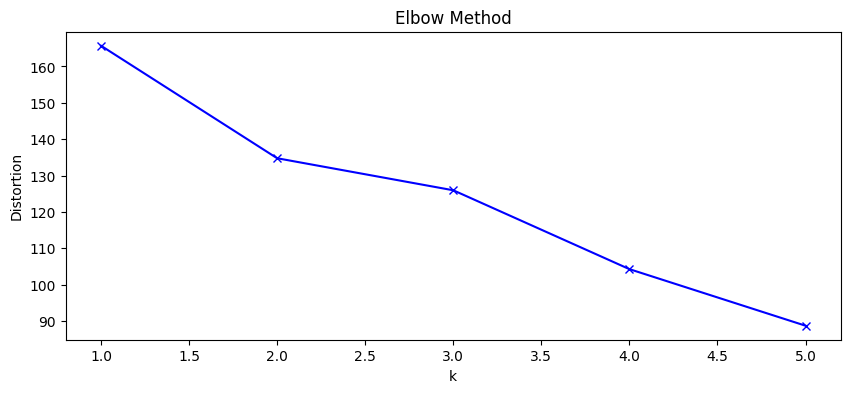

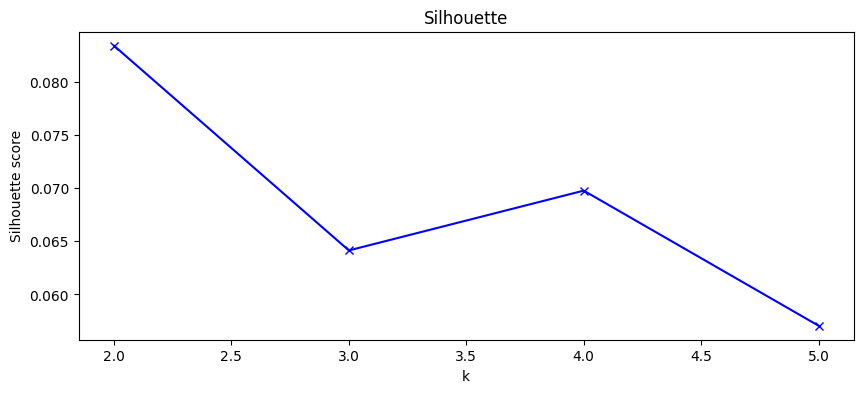

In [52]:
%%time

# Run the algorithm using DTW algorithm 
get_kmeans_results(data=scaled_ts, max_clusters=5, metric='dtw', seed=SEED)

In [53]:
def plot_clusters(data, cluster_model, dim_red_algo):
    """
    Plots clusters obtained by clustering model 

    data: pd.DataFrame or np.array
        Time Series Data
    cluster_model: Class
        Clustering algorithm 
    dim_red_algo: Class
        Dimensionality reduction algorithm (e.g. TSNE/PCA/MDS...) 
    Returns:
    -------
    None
    """
    cluster_labels = cluster_model.fit_predict(data)
    centroids = cluster_model.cluster_centers_
    u_labels = np.unique(cluster_labels)
    
    # Centroids Visualization
    plt.figure(figsize=(16, 10))
    plt.scatter(centroids[:, 0] , centroids[:, 1] , s=150, color='r', marker="x")
    
    # Downsize the data into 2D
    if data.shape[1] > 2:
        data_2d = dim_red_algo.fit_transform(data)
        for u_label in u_labels:
            cluster_points = data[(cluster_labels == u_label)]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=u_label)
    else:
        for u_label in u_labels:
            cluster_points = data[(cluster_labels == u_label)]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=u_label)

    plt.title('Clustered Data')
    plt.xlabel("Feature space for the 1st feature")
    plt.ylabel("Feature space for the 2nd feature")
    plt.grid(True)
    plt.legend(title='Cluster Labels');

CPU times: total: 2min 12s
Wall time: 1min 45s


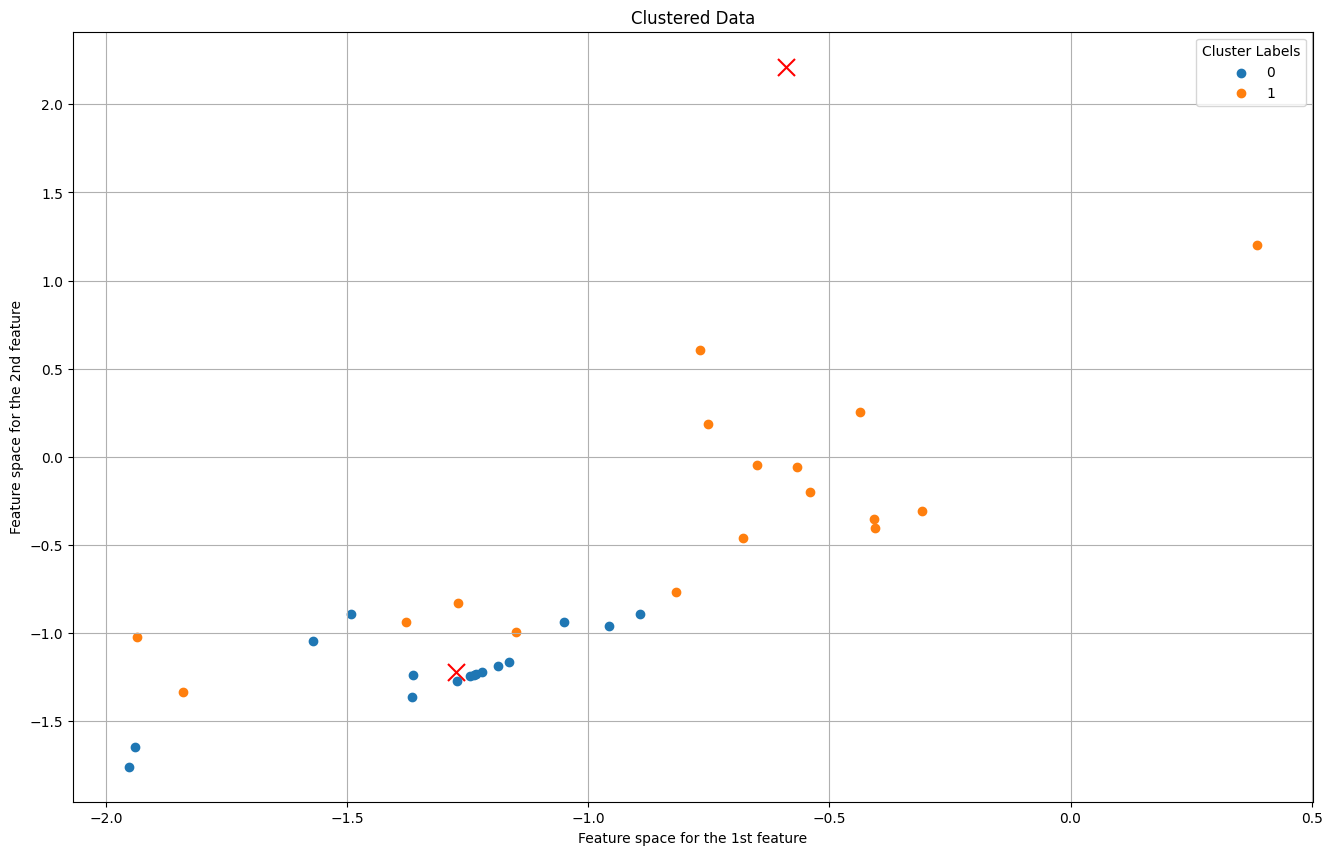

In [54]:
%%time

# let's look at the cluster shape
model = TimeSeriesKMeans(n_clusters=2, metric='dtw', n_jobs=-1, max_iter=10, random_state=SEED)

plot_clusters(data=scaled_ts,
              cluster_model=model,
              dim_red_algo=TSNE(n_components=2, init='pca', random_state=SEED))

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 57.53it/s]


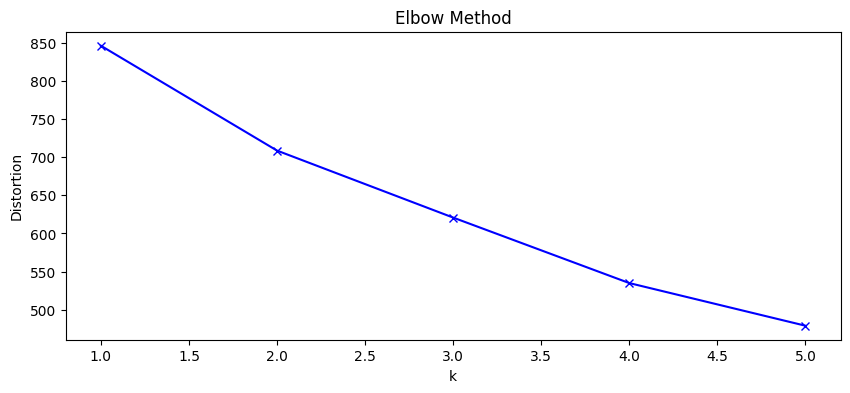

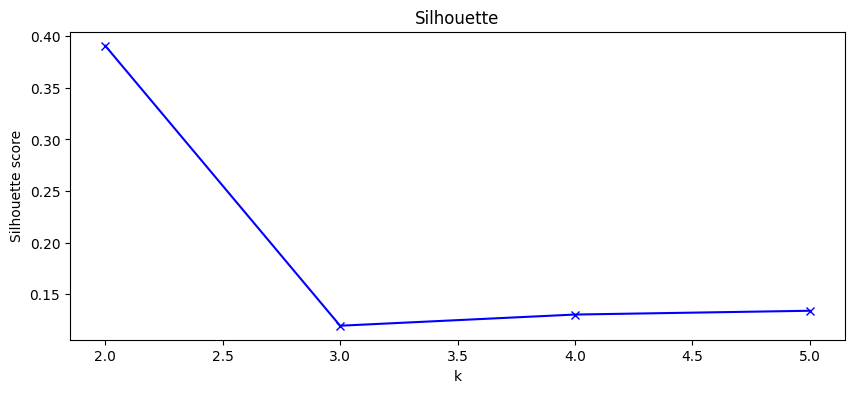

In [55]:
get_kmeans_results(data=scaled_ts, max_clusters=5, metric='euclidean', seed=SEED)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 57.08it/s]


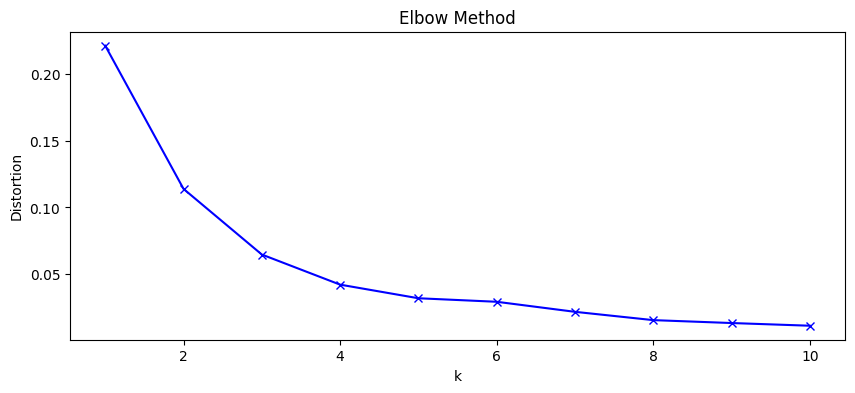

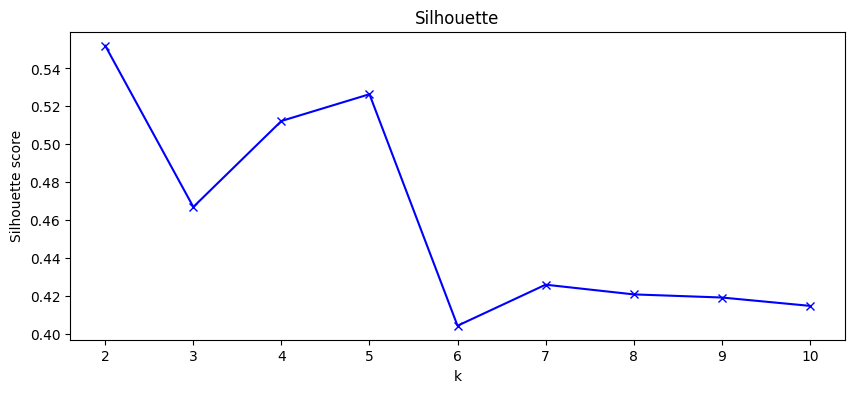

In [56]:
# Downsize the features into 2D
tsne = TSNE(n_components=2, init='pca', random_state=SEED)
data_tsne = tsne.fit_transform(scaled_ts)

get_kmeans_results(data=data_tsne, max_clusters=10, metric='euclidean', seed=SEED)

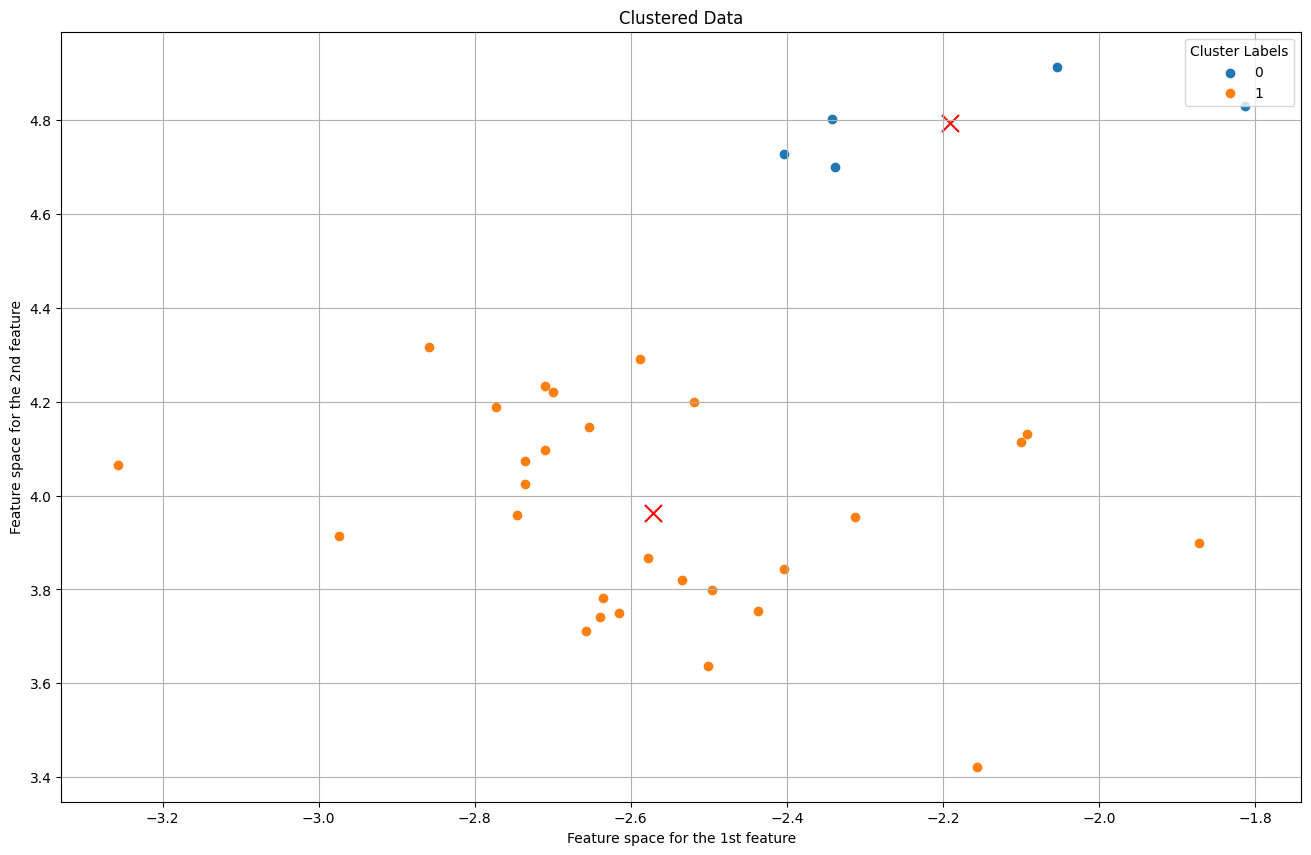

In [57]:
# let's look at the cluster shape
model = TimeSeriesKMeans(n_clusters=2, metric='euclidean', n_jobs=-1, max_iter=10, random_state=SEED)

plot_clusters(data=data_tsne,
              cluster_model=model,
              dim_red_algo=TSNE(n_components=2, init='pca', random_state=SEED))

C:\Python310\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 57.12it/s]


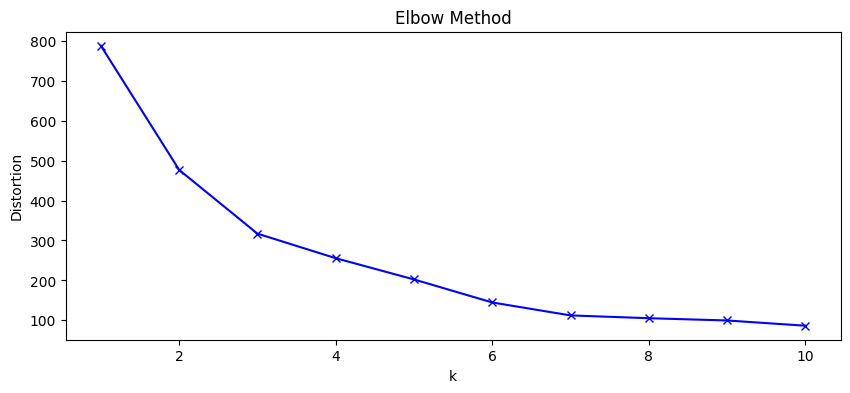

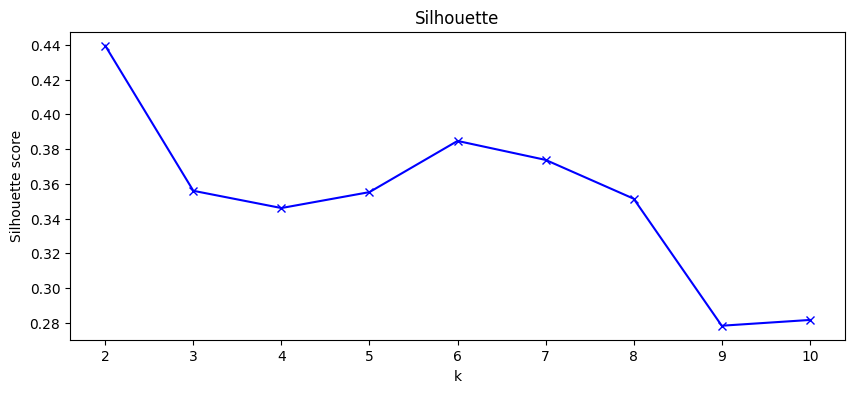

In [61]:
mds = MDS(n_components=2, n_init=3, max_iter=100, random_state=SEED)
data_mds = mds.fit_transform(scaled_ts) 

get_kmeans_results(data=data_mds, max_clusters=10, metric='euclidean', seed=SEED)

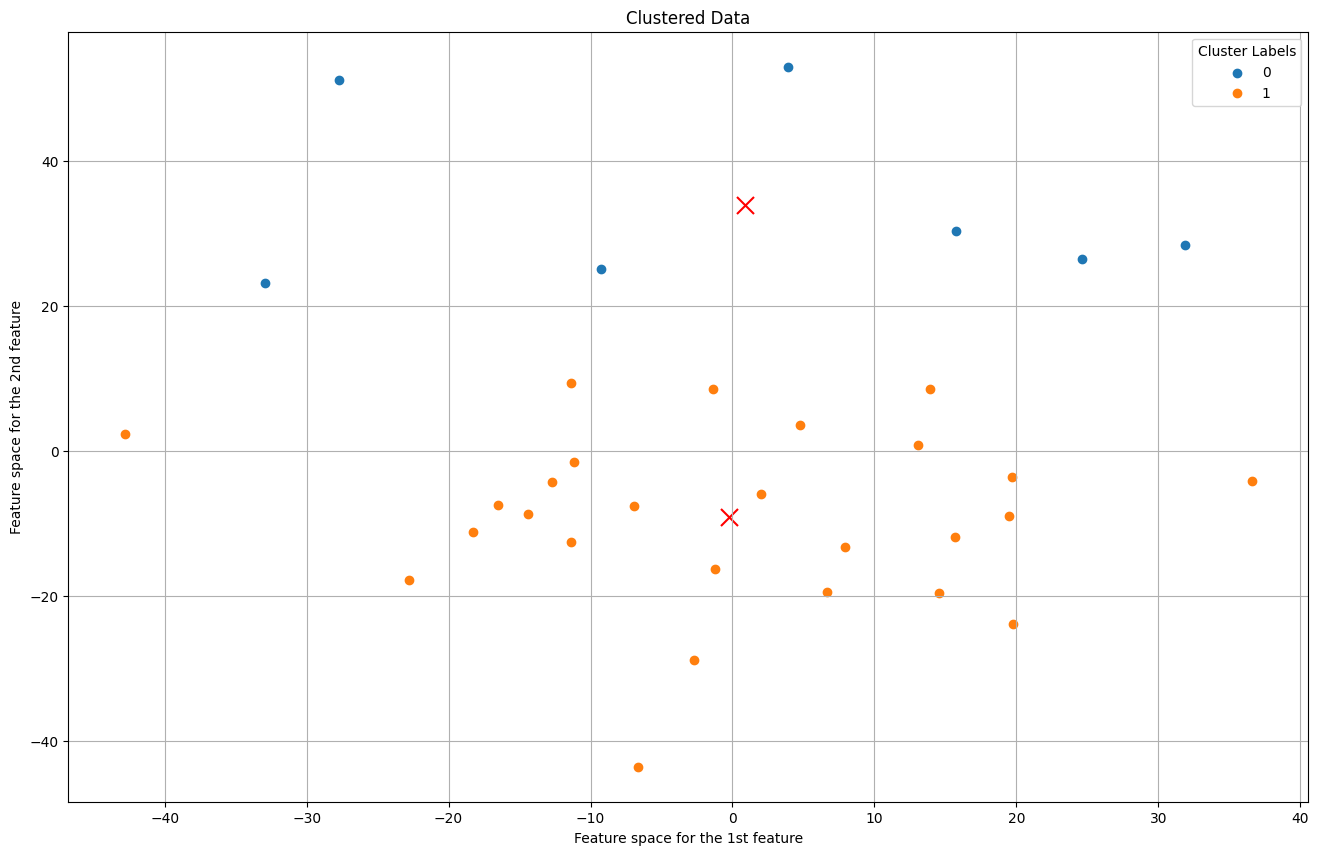

In [62]:
# let's look at the cluster shape
model = TimeSeriesKMeans(n_clusters=2, metric='euclidean', n_jobs=-1, max_iter=10, random_state=SEED)

plot_clusters(data=data_mds,
              cluster_model=model,
              dim_red_algo=TSNE(n_components=2, init='pca', random_state=SEED))

In [63]:
# Train TimeSeriesKMeans with MDS
kmeans_model = TimeSeriesKMeans(n_clusters=5, metric='euclidean', n_jobs=-1, max_iter=10, random_state=SEED)
cluster_labels = kmeans_model.fit_predict(data_mds)

ts_clustered = [ scaled_ts[(cluster_labels == lable), :] for lable in np.unique(cluster_labels)]

In [58]:
def plot_cluster_ts(current_cluster):
    """
    Plots time series in a cluster 

    current_cluster: np.array
        Cluster with time series 
    Returns:
    -------
    None 
    """
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0]/4)),4,
        figsize=(45, 3*int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)
    for indx, series in enumerate(current_cluster):
        ax[indx].plot(series)
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show();

==========Cluster number: 0==========


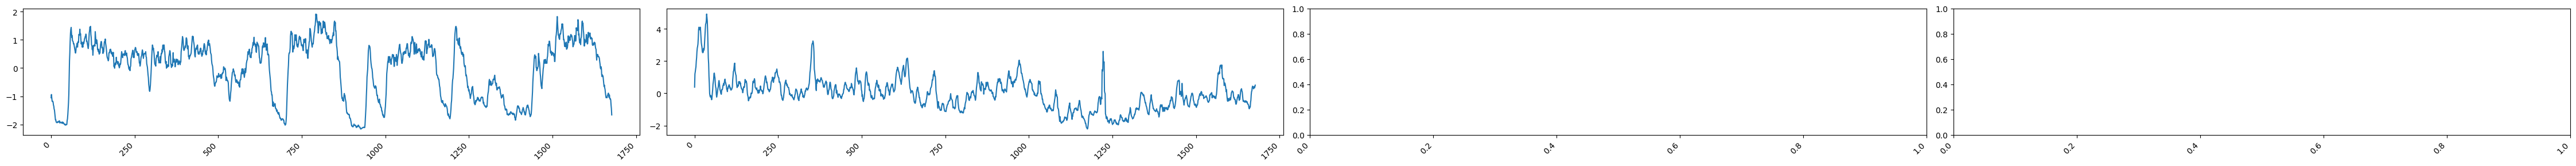

==========Cluster number: 1==========


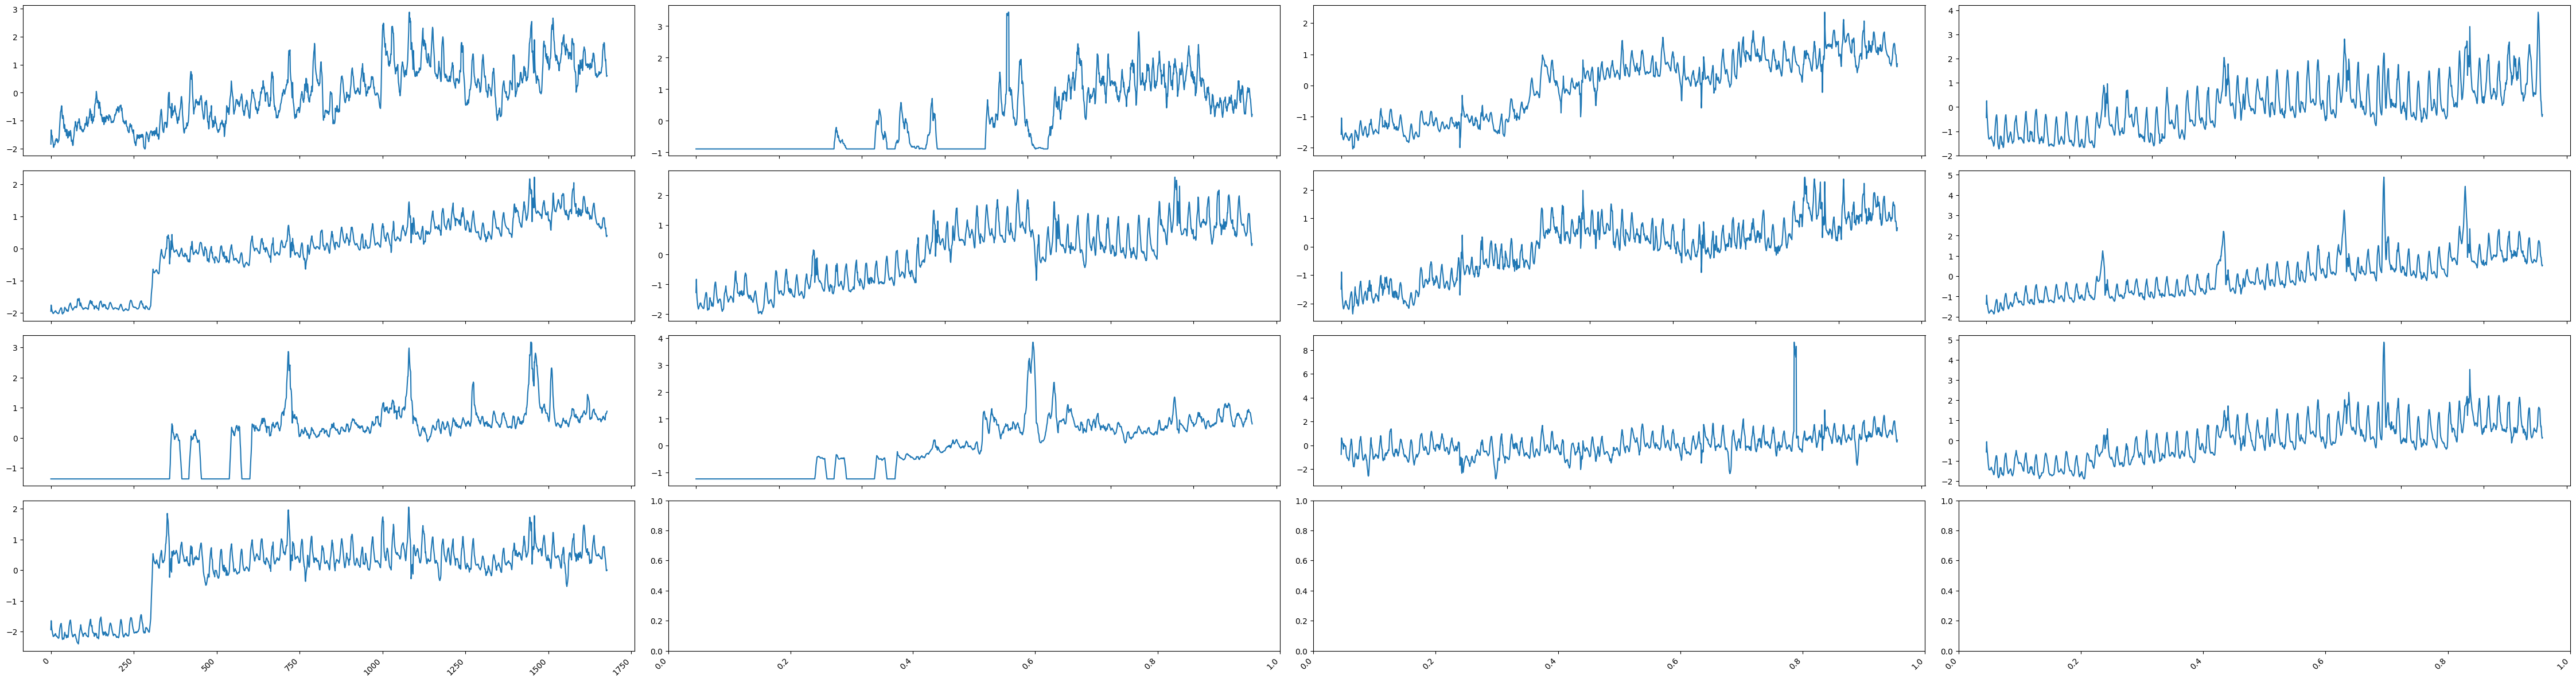

==========Cluster number: 2==========


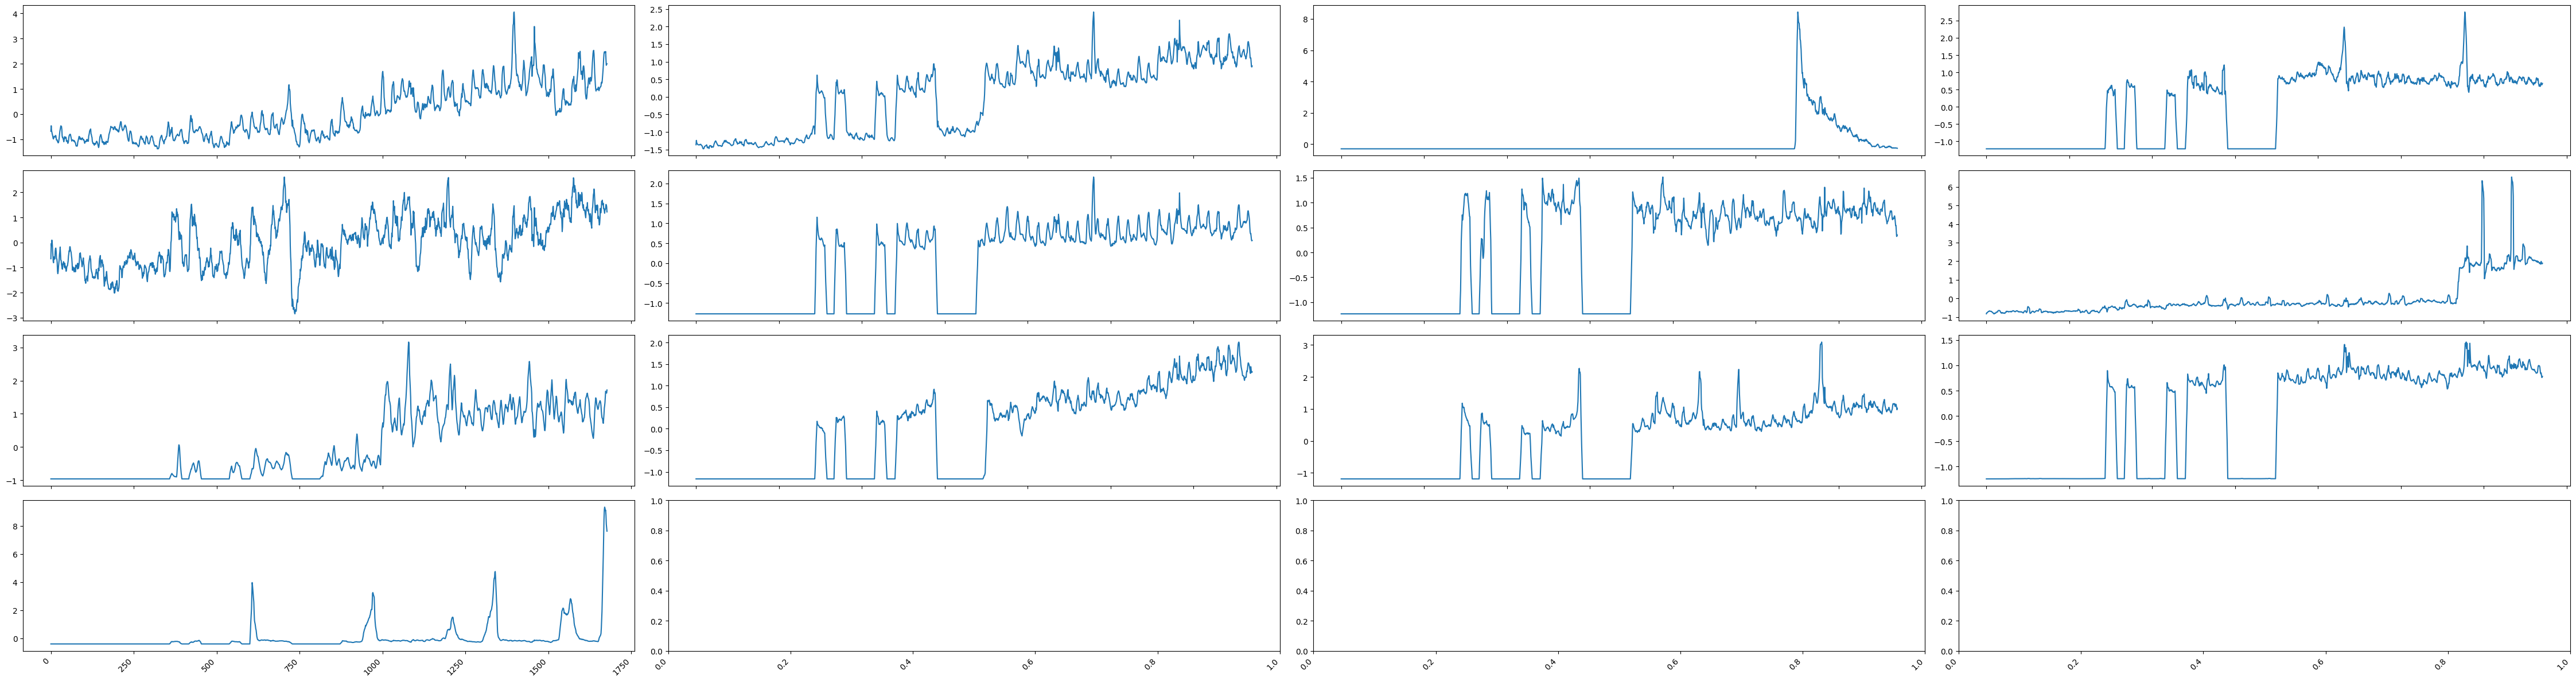

==========Cluster number: 3==========


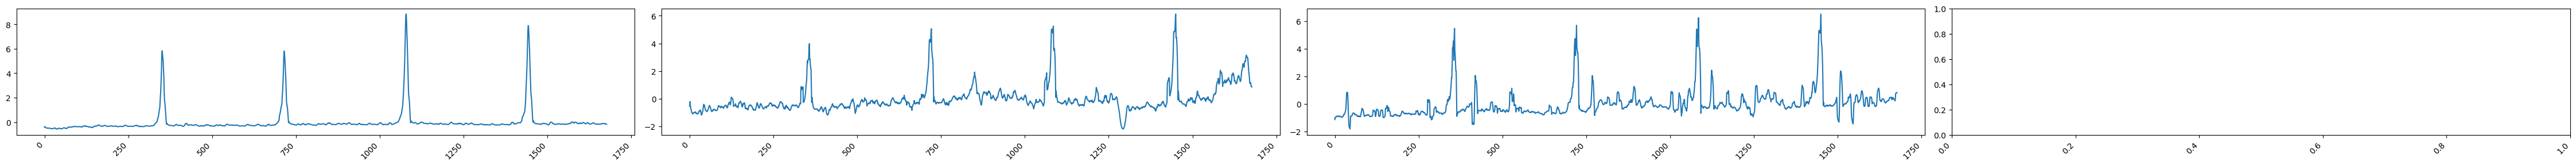

==========Cluster number: 4==========


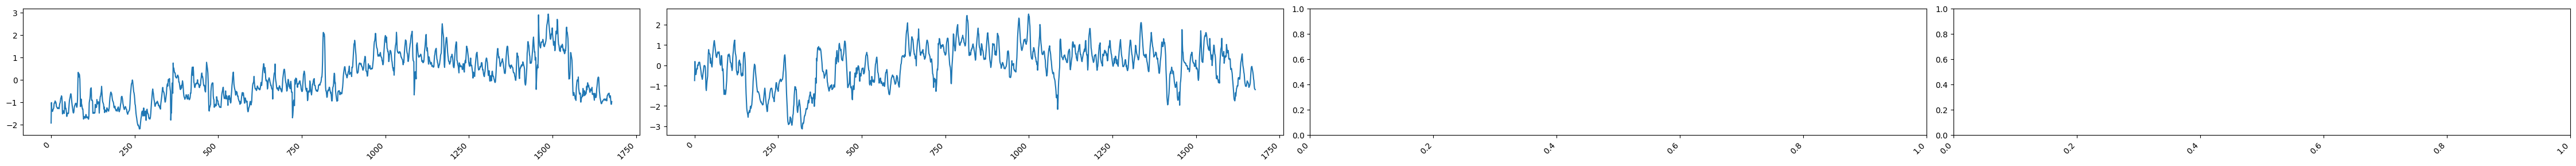

In [64]:
for cluster in range(len(ts_clustered)):
    print(f"==========Cluster number: {cluster}==========")
    plot_cluster_ts(ts_clustered[cluster])

In [67]:
pip install vrae

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement vrae (from versions: none)
ERROR: No matching distribution found for vrae

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [68]:
from vrae.vrae import VRAE
from vrae.utils import *

import torch
import plotly
from torch.utils.data import DataLoader, TensorDataset
plotly.offline.init_notebook_mode()

In [69]:
vrae_df = scaled_ts.copy()
dload = '/content/timeseries_clustering_vae/' 

In [70]:
# Model Params
hidden_size = 50
hidden_layer_depth = 1
latent_length = 20
batch_size = 5
learning_rate = 0.005
n_epochs = 40
dropout_rate = 0.1
optimizer = 'Adam' # Adam/SGD
cuda = True # Train on GPU
print_every=30
clip = True 
max_grad_norm=5
loss = 'MSELoss' # SmoothL1Loss/MSELoss
block = 'LSTM' # LSTM/GRU

In [71]:
# We don't use test_df, create train_df using all the data we have
X_train = np.expand_dims(scaled_ts, -1)
train_dataset = TensorDataset(torch.from_numpy(X_train))

sequence_length = X_train.shape[1] 
number_of_features = X_train.shape[2] 

In [72]:
# Model Creation 
vrae = VRAE(sequence_length=sequence_length,
            number_of_features = number_of_features,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            optimizer = optimizer, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            loss = loss,
            block = block,
            dload = dload)

C:\Python310\lib\site-packages\torch\nn\modules\rnn.py:67: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1

C:\Python310\lib\site-packages\torch\nn\_reduction.py:42: UserWarning:

size_average and reduce args will be deprecated, please use reduction='sum' instead.



In [77]:
%%time 

vrae.fit(train_dataset)

Epoch: 0
Average loss: 10221.0068
Epoch: 1
Average loss: 10199.4680
Epoch: 2
Average loss: 10111.1842
Epoch: 3
Average loss: 10091.9568
Epoch: 4
Average loss: 10065.9924
Epoch: 5
Average loss: 10061.4537
Epoch: 6
Average loss: 10069.3826
Epoch: 7
Average loss: 10045.5822
Epoch: 8
Average loss: 10024.6477
Epoch: 9
Average loss: 10783.3428
Epoch: 10
Average loss: 10285.2213
Epoch: 11
Average loss: 10072.8219
Epoch: 12
Average loss: 10883.9604
Epoch: 13
Average loss: 11807.6154
Epoch: 14
Average loss: 10043.6496
Epoch: 15
Average loss: 11753.6686
Epoch: 16
Average loss: 10492.8852
Epoch: 17
Average loss: 10449.4996
Epoch: 18
Average loss: 10085.4639
Epoch: 19
Average loss: 10072.3391
Epoch: 20
Average loss: 10064.7617
Epoch: 21
Average loss: 10059.3498
Epoch: 22
Average loss: 10056.3697
Epoch: 23
Average loss: 10048.9611
Epoch: 24
Average loss: 10024.6773
Epoch: 25
Average loss: 12917.4123
Epoch: 26
Average loss: 10910.2170
Epoch: 27
Average loss: 10413.6387
Epoch: 28
Average loss: 10533.

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 56.32it/s]


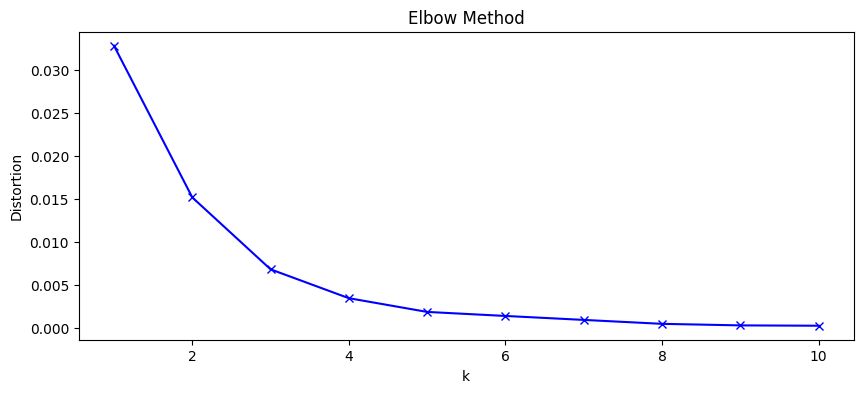

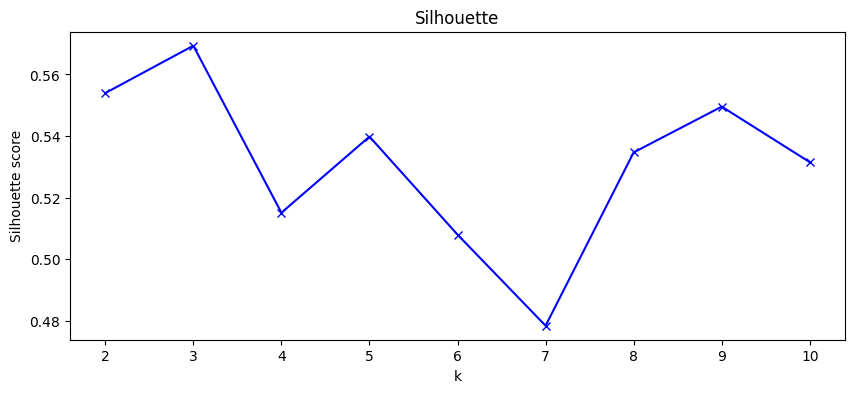

In [78]:
# Get embeddings
embeddings = vrae.transform(train_dataset)

# Cluster the embeddings
get_kmeans_results(data=embeddings, max_clusters=10, metric='euclidean', seed=SEED)

(30, 20)

ValueError: perplexity must be less than n_samples

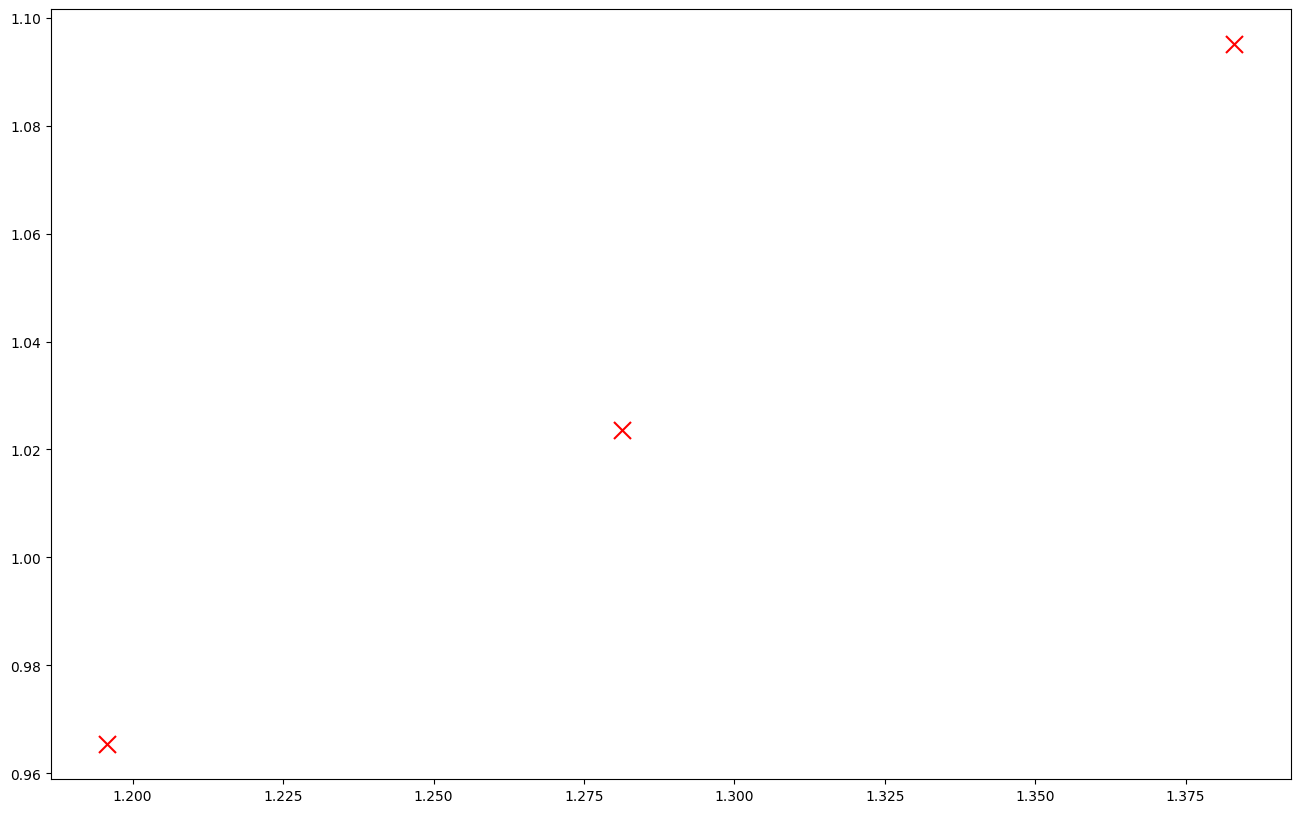

In [79]:
model = TimeSeriesKMeans(n_clusters=3, metric='euclidean', n_jobs=-1, max_iter=10, random_state=SEED)
 
plot_clusters(data=embeddings,
              cluster_model=model,
              dim_red_algo=TSNE(n_components=2, init='pca', random_state=SEED))

In [9]:
df_daily_sales = df_train.groupby('date')['sales'].sum().reset_index()
df_daily_sales['date'] = pd.to_datetime(df_daily_sales['date'])
#use rolling avg for SARIMA
df_daily_sales['rolling_average_7_day'] = df_daily_sales['sales'].rolling(window=7).mean() 

#Set index to be date
df_daily_sales.set_index('date', inplace=True)
df_daily_sales.sort_index(inplace=True)